# Lublin House Prices Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing

In [59]:
data = pd.read_csv('data/houses_data.csv')

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     3182 non-null   object
 1   Name      3182 non-null   object
 2   Rooms     3182 non-null   object
 3   Area      3182 non-null   object
 4   Floor     3121 non-null   object
 5   Region    3182 non-null   object
 6   Year      3182 non-null   object
 7   Elevator  3182 non-null   object
dtypes: object(8)
memory usage: 199.0+ KB


In [61]:
data = data.drop("Name", axis=1)

In [62]:
print("\nUnique values in each column (excluding 'Price' and 'Area'):")
for column in data.columns:
    if column not in ['Price', 'Area']:
        unique_values = data[column].unique()
        print(f"{column}: {unique_values}")


Unique values in each column (excluding 'Price' and 'Area'):
Rooms: ['4 pokoje' '2 pokoje' '3 pokoje' '1 pokój' '5 pokoi' '6 pokoi'
 '10+ pokoi' '7 pokoi']
Floor: ['3 piętro' '2 piętro' '1 piętro' nan '10+ piętro' '10 piętro' '4 piętro'
 'parter' '6 piętro' '5 piętro' '9 piętro' '7 piętro' '8 piętro'
 'suterena' 'poddasze']
Region: ['Rury' 'Czechów Północny' 'Wrotków' 'Czechów Południowy' 'Kośminek'
 'Wieniawa' 'Ponikwoda' 'Śródmieście' 'Bronowice' 'Węglin Południowy'
 'Dziesiąta' 'Tatary' 'Felin' 'Kalinowszczyzna' 'Sławin' 'Czuby Północne'
 'Konstantynów' 'Szerokie' 'Czuby Południowe' 'Stare Miasto'
 'Za Cukrownią' 'Zemborzyce' 'Węglin Północny' 'Hajdów-Zadębie']
Year: ['brak informacji' '2025' '2026' '2023' '2015' '1980' '1982' '2008' '2024'
 '2018' '2003' '2021' '1976' '1963' '2017' '1969' '2000' '1978' '1975'
 '1983' '1993' '1974' '1995' '2022' '1994' '1897' '1986' '1984' '2010'
 '1988' '1973' '1996' '1967' '1972' '1964' '1998' '2014' '1990' '1977'
 '2005' '2012' '2016' '1985' '19

### Change the data type of the columns

In [63]:
# Replace 'Zapytaj o cenę' with NaN
data['Price'] = data['Price'].replace('Zapytaj o cenę', np.nan)
# Remove non-numeric characters, replace commas with dots, and convert to float, while keeping NaN values
data['Price'] = data['Price'].str.replace('\xa0', '').str.replace('zł', '').str.replace(',', '.').astype('float32')

In [64]:
# Remove non-numeric characters and convert 'Area' to float
data['Area'] = data['Area'].str.replace(' ', '').str.replace('m²', '').astype('float32')

In [65]:
# Replace 'brak informacji' with NaN in 'Year' column
data['Year'] = data['Year'].replace('brak informacji', np.nan)
# Convert 'Year' to integer, while keeping NaN values
data['Year'] = data['Year'].astype(float).astype('Int32')

In [66]:
# Convert 'Elevator' column to 0 if 'nie' and 1 if 'tak'
data['Elevator'] = data['Elevator'].replace({'nie': 0, 'tak': 1}).astype('int32')

C:\Users\davyd\AppData\Local\Temp\ipykernel_5020\190091281.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Elevator'] = data['Elevator'].replace({'nie': 0, 'tak': 1}).astype('int32')


In [67]:
# Count the number of rows for each unique value in 'Rooms' column
room_counts = data['Rooms'].value_counts()
print("Number of rows for each unique value in 'Rooms' column:")
print(room_counts)

Number of rows for each unique value in 'Rooms' column:
Rooms
3 pokoje     1364
2 pokoje     1124
4 pokoje      404
1 pokój       232
5 pokoi        46
6 pokoi         7
7 pokoi         3
10+ pokoi       2
Name: count, dtype: int64


In [68]:
# Replace '10+ pokoi' with '10 pokoi' in 'Rooms' column
data['Rooms'] = data['Rooms'].replace('10+ pokoi', '10 pokoi')
# Extract numeric part and convert 'Rooms' to integer
data['Rooms'] = data['Rooms'].str.extract('(\d+)').astype('int32')

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
C:\Users\davyd\AppData\Local\Temp\ipykernel_5020\158739740.py:4: SyntaxWarning: invalid escape sequence '\d'
  data['Rooms'] = data['Rooms'].str.extract('(\d+)').astype('int32')


In [69]:
# Drop rows with missing values in 'Price' column
data = data.dropna(subset=['Price'])

In [70]:
# Reorder columns
data = data[['Price', 'Area', 'Elevator', 'Year', 'Rooms', 'Floor', 'Region']]

In [71]:
# Assuming 'data' is your DataFrame
missing_data = data.isnull().sum()
print("Missing data in each column:")
print(missing_data)

Missing data in each column:
Price         0
Area          0
Elevator      0
Year        430
Rooms         0
Floor        61
Region        0
dtype: int64


In [72]:
data.head()

,Price,Area,Elevator,Year,Rooms,Floor,Region
0,567000.0,52.500000,0,<NA>,4,3 piętro,Rury
1,728500.0,77.500000,1,2025,4,3 piętro,Czechów Północny
2,668360.0,68.199997,1,2026,4,2 piętro,Wrotków
3,833414.0,76.459999,1,2023,4,1 piętro,Czechów Południowy
4,696500.0,79.599998,1,2025,4,NaN,Kośminek


In [73]:
data.dtypes

Price       float32
Area        float32
Elevator      int32
Year          Int32
Rooms         int32
Floor        object
Region       object
dtype: object

In [74]:
# Calculate the number of rows with both 'Floor' and 'Region' missing values
missing_floor_region = data[data['Floor'].isnull() & data['Region'].isnull()].shape[0]
print(f"Number of rows with both 'Floor' and 'Region' missing values: {missing_floor_region}")

Number of rows with both 'Floor' and 'Region' missing values: 0


There are 0 rows which has mising values at the same time in the columns 'Floor' and 'Region', so it is bad idea to drop all NA values, because we will lose near 500 rows from the dataset. Instead of this, we will fill the missing values in the 'Floor' column with the median value.

### Impute missing values

#### Floors

Use median value to fill missing values in the 'Floor' column.

In [79]:
# Count the occurrences of each unique value in the 'Floor' column
floor_counts = data['Floor'].value_counts(dropna=False)
# Display the counts for each unique value
print("Number of rows for each unique value in 'Floor' column:")
print(floor_counts)

Number of rows for each unique value in 'Floor' column:
Floor
3 piętro      549
2 piętro      541
1 piętro      531
parter        491
4 piętro      285
5 piętro      112
6 piętro       73
NaN            61
7 piętro       50
10 piętro      32
9 piętro       31
8 piętro       15
10+ piętro      8
suterena        1
poddasze        1
Name: count, dtype: int64


Change 10+ piętro and poddasze to 10 piętro, suterena to parter

In [80]:
data['Floor'] = data['Floor'].replace({
    'suterena': 'parter',
    'poddasze': 'parter',
    '10+ piętro': '10 piętro'
})

In [86]:
# Extract numeric part from 'Floor' column, forcing errors to NaN
floor_numeric = data['Floor'].str.extract(r'(\d+)').astype(float)
# Calculate the median of the 'Floor' column, excluding NaN values
median_floor = floor_numeric.dropna().median()[0]
print(f"Median of the 'Floor' column: {median_floor}")

Median of the 'Floor' column: 3.0


In [90]:
# Replace all NaN values in 'Floor' column with '3 piętro'
data['Floor'] = data['Floor'].fillna('3 piętro')

#### Years

Year column has very large number of missing values, so we will fill them with regression but first check the correlation between the year and other columns.

In [117]:
data['Year'] = data['Year'].replace({87: 1987, 1: np.nan})

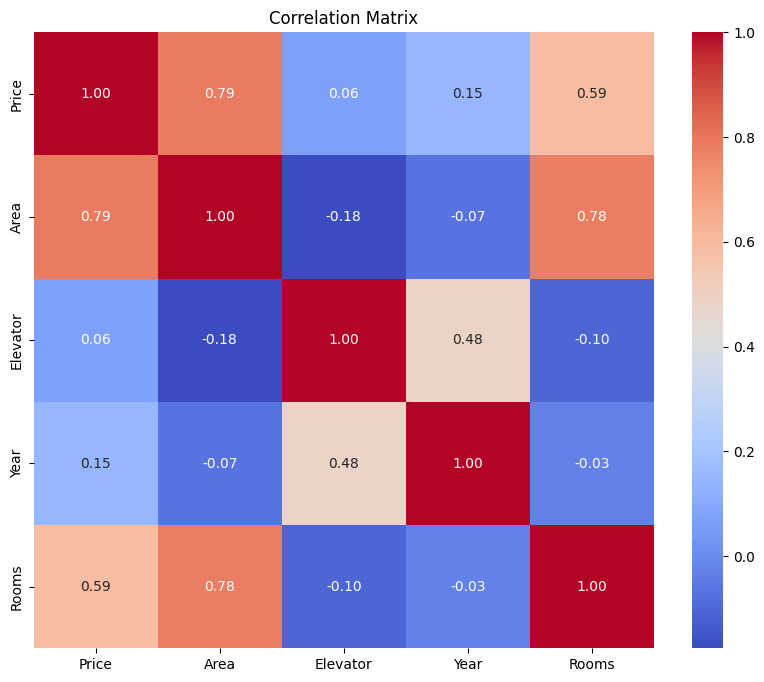

In [120]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Year column has very low correlation with other columns, only with the Elevator column has correlation approximately 0.5, so we will make a column `Year_interval` and fill missing values with year interval of the building and also consider whether there is a lift in the building, as older buildings may not have one

Make new column `Year_interval`.

In [121]:
# Define the bins and labels for the intervals
bins = [-np.inf, 1890, 1920, 1950, 1980, 2001, 2016, np.inf]
labels = ['<1890', '1891-1920', '1921-1950', '1951-1980', '1981-2001', '2001-2016', '2016<']

# Create the 'Year_interval' column using pd.cut()
data['Year_interval'] = pd.cut(data['Year'], bins=bins, labels=labels, right=False)

# Display the first few rows to verify the changes
print(data[['Year', 'Year_interval']].head())

   Year Year_interval
0  <NA>           NaN
1  2025         2016<
2  2026         2016<
3  2023         2016<
4  2025         2016<


In [122]:
data["Year_interval"].value_counts()

Year_interval
2016<        1232
1951-1980     426
1981-2001     365
2001-2016     238
1891-1920      45
1921-1950      39
<1890           5
Name: count, dtype: int64

See that most building are in 2016< and 1951-1980 years, so we will fill missing values with these intervals, depending on the availability of a elevator.

In [129]:
def fill_year_interval(row):
    if pd.isna(row['Year_interval']):
        if row['Elevator'] == 1:
            return '2016<'
        else:
            return '1951-1980'
    else:
        return row['Year_interval']

In [130]:
data['Year_interval'] = data.apply(fill_year_interval, axis=1)

In [132]:
data = data[['Price', 'Area', 'Elevator', 'Rooms', 'Floor', 'Region','Year_interval','Year']]

In [134]:
data.to_csv('data/houses_data_cleaned.csv', index=False)

## Exploratory Data Analysis

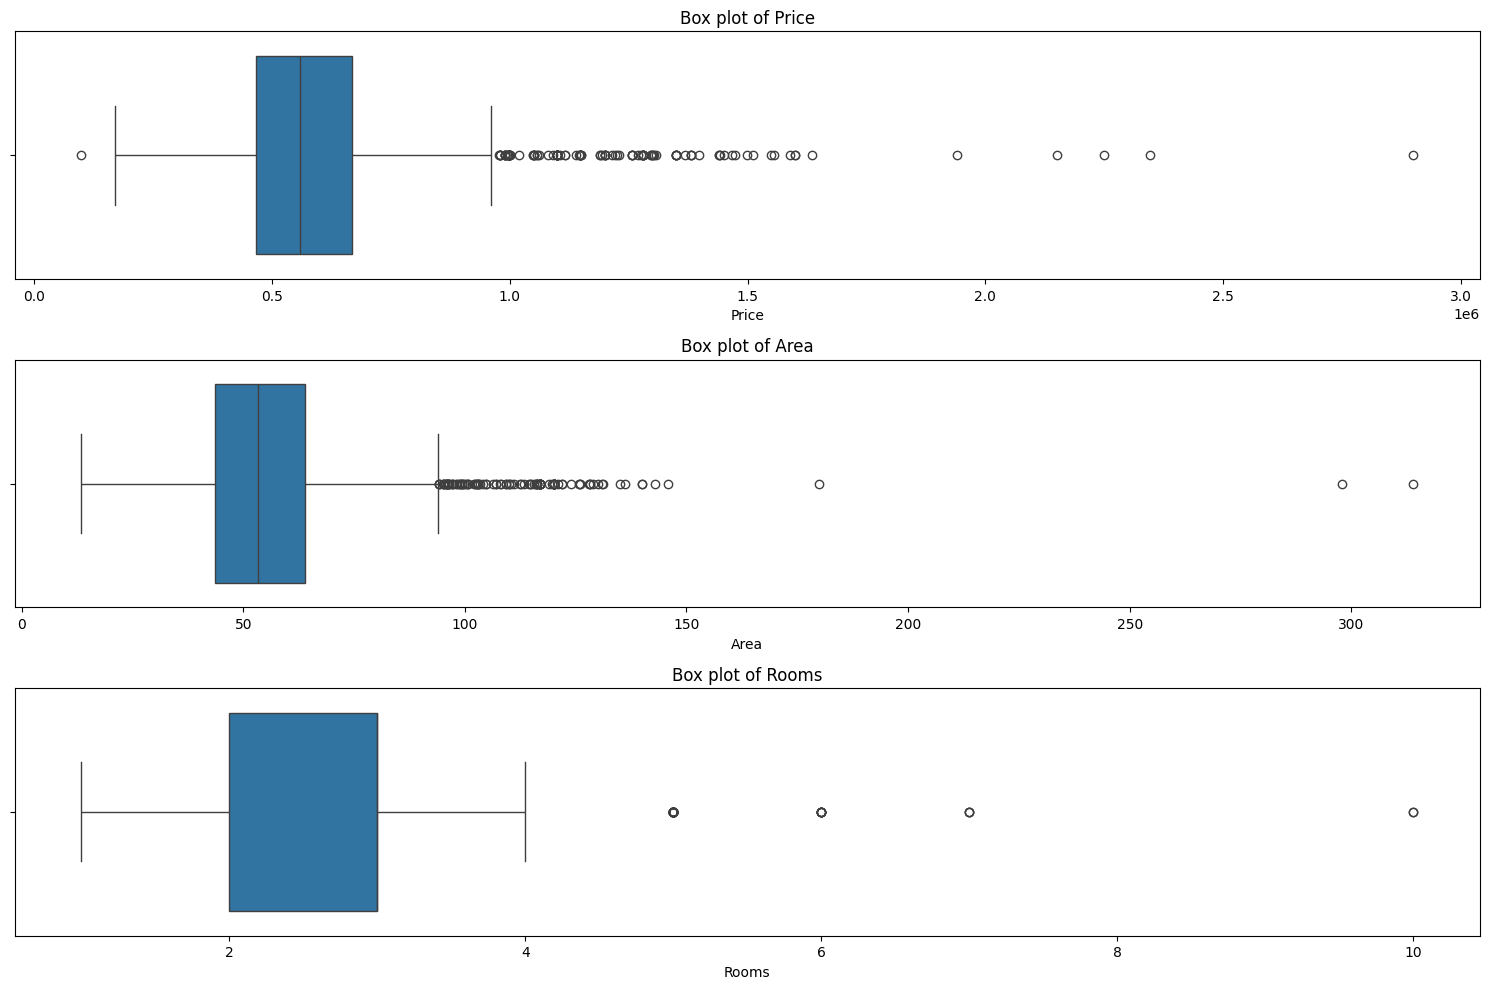

In [147]:
numerical_columns = ['Price', 'Area', 'Rooms']
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 1, i)
    sns.boxplot(x=data[column], orient='h')
    plt.title(f'Box plot of {column}')
    plt.xlabel(column)
plt.tight_layout()
plt.show()

**Box Plot of Price**
Most house prices fall within a certain range, with a few outliers extending significantly beyond 1,500,000 PLN. The median price is located in the lower portion of the box, suggesting that most properties are closer to the lower price range.

**Box Plot of Area**
Most house areas are between approximately 30 sqm and 100 sqm, with the interquartile range (IQR) centered on typical apartment sizes.There are several outliers representing houses with exceptionally large areas (e.g., over 200 sqm).

**Box Plot of Rooms:**
Most houses have between 2 and 4 rooms, which matches the common configurations of apartments.

Lest explore anomalies in the data to see if we can find any patterns in them and shoul we remove them or not.

Use the Interquartile Range (IQR) Method to detect and see the anomalies in the data.

In [166]:
def find_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

price_outliers = find_outliers_iqr(data, 'Price')
area_outliers = find_outliers_iqr(data, 'Area')
room_outliers = find_outliers_iqr(data, 'Rooms')

all_outliers = pd.concat([price_outliers, area_outliers, room_outliers]).drop_duplicates()
all_outliers.head(20)

,Price,Area,Elevator,Rooms,Floor,Region,Year_interval,Year,Price_per_sqm,Outlier_DBSCAN
168,1350000.0,117.000000,1,4,2 piętro,Stare Miasto,2001-2016,2013,11538.461914,0
170,1599000.0,116.879997,1,5,6 piętro,Konstantynów,2016<,2018,13680.698242,0
203,1499000.0,88.199997,1,4,10 piętro,Czechów Południowy,2016<,2019,16995.464844,0
217,1080000.0,72.000000,0,4,parter,Śródmieście,1891-1920,1908,15000.000000,0
233,1299000.0,81.000000,1,3,10 piętro,Rury,2001-2016,2013,16037.037109,0
330,1099500.0,82.570000,1,4,3 piętro,Wrotków,2016<,<NA>,13315.974609,0
337,99000.0,19.000000,0,1,parter,Dziesiąta,1951-1980,<NA>,5210.526367,0
347,1050000.0,77.000000,0,3,1 piętro,Sławin,2016<,2023,13636.363281,0
356,1280000.0,92.000000,0,4,1 piętro,Sławin,2016<,2020,13913.043945,0
390,1149990.0,91.989998,0,4,1 piętro,Sławin,2016<,2019,12501.250000,0


In [167]:
len(all_outliers)

160

IQR method detected very large number of annomalies in the data, so we will not remove them, because they are not errors in the data, but just outliers, because there are some very expensive houses in Lublin.

Use DBSCAN to detect anomalies in the data.

In [190]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
numeric_data = data[['Price', 'Area', 'Rooms']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)
dbscan = DBSCAN(eps=1.5, min_samples=5)
data['Outlier_DBSCAN'] = dbscan.fit_predict(scaled_data)
dbscan_outliers = data[data['Outlier_DBSCAN'] == -1]
dbscan_outliers.head(15)

,Price,Area,Elevator,Rooms,Floor,Region,Year_interval,Year,Price_per_sqm,Outlier_DBSCAN
210,499000.0,128.000000,0,4,4 piętro,Tatary,1951-1980,1960,3898.437500,-1
800,1940000.0,314.000000,0,10,3 piętro,Wieniawa,1951-1980,<NA>,6178.343750,-1
1136,950000.0,90.830002,0,7,4 piętro,Śródmieście,1921-1950,1930,10459.099609,-1
2552,2150000.0,130.000000,1,4,10 piętro,Czechów Południowy,2001-2016,2013,16538.460938,-1
2643,2347058.0,145.779999,1,4,7 piętro,Śródmieście,2016<,2024,16100.000000,-1
2866,475000.0,124.000000,0,5,1 piętro,Kośminek,1981-2001,1980,3830.645264,-1
2937,2900000.0,298.000000,0,10,1 piętro,Szerokie,2001-2016,2003,9731.543945,-1
3056,999000.0,180.000000,0,5,3 piętro,Czechów Północny,1981-2001,1998,5550.000000,-1
3098,2250000.0,131.199997,1,5,10 piętro,Czechów Południowy,2016<,2020,17149.390625,-1


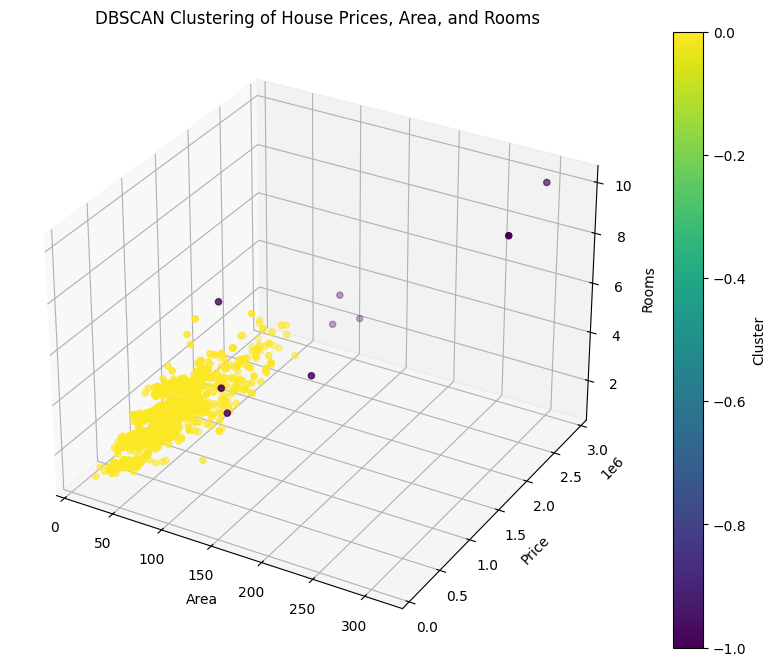

In [191]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data['Area'], data['Price'], data['Rooms'], c=data['Outlier_DBSCAN'], cmap='viridis', marker='o')
ax.set_xlabel('Area')
ax.set_ylabel('Price')
ax.set_zlabel('Rooms')
ax.set_title('DBSCAN Clustering of House Prices, Area, and Rooms')
fig.colorbar(scatter, label='Cluster')
plt.show()

DBSCAN detected 9 anomalies what is much better than IQR method, but if look at that data we can see that with them is everythink ok, so we will not remove them.

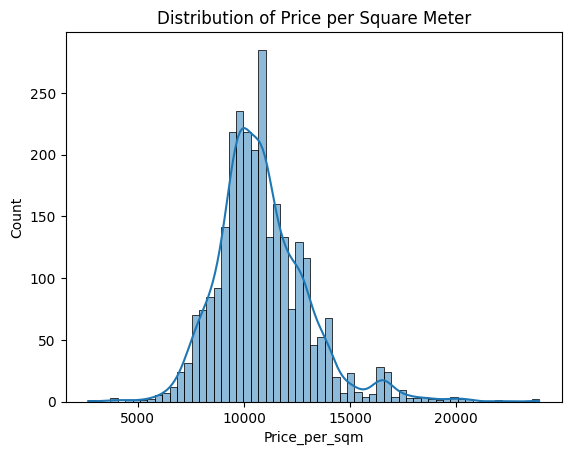

In [149]:
data.loc[:, 'Price_per_sqm'] = data['Price'] / data['Area']
sns.histplot(data=data, x='Price_per_sqm', kde=True)
plt.title('Distribution of Price per Square Meter')
plt.show()

The distribution is unimodal, with a clear peak around 10,000 PLN per square meter. This suggests that the majority of houses in Lublin have a price per square meter near this value.

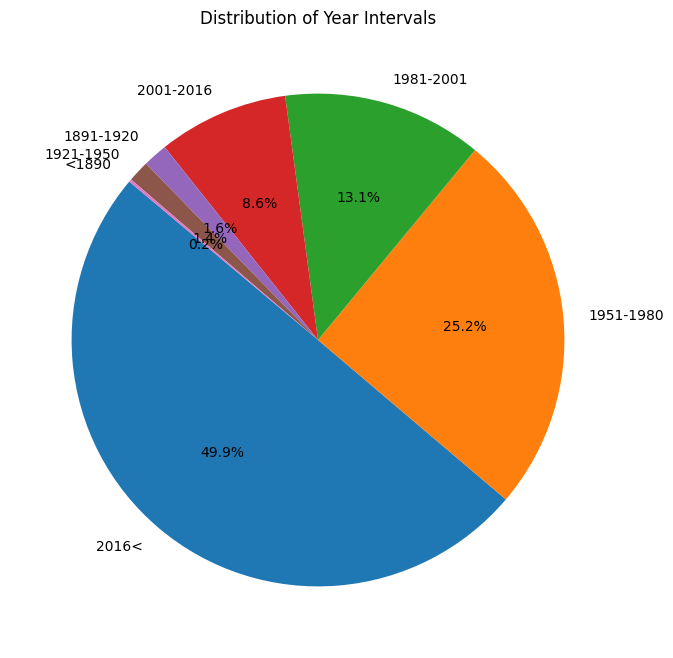

In [158]:
year_interval_counts = data['Year_interval'].value_counts()

# Create a pie plot
plt.figure(figsize=(8, 8))
plt.pie(year_interval_counts, labels=year_interval_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Year Intervals')
plt.show()

## Data preparation

In [2]:
data = pd.read_csv('data/houses_data_cleaned.csv')

In [6]:
# Separate target and features
target = data['Price']
features = data.drop('Price', axis=1)

In [8]:
from sklearn.preprocessing import OneHotEncoder
# One-Hot Encoding for categorical variables
categorical_columns = ['Floor', 'Region', 'Year_interval']
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
encoded_cats = pd.DataFrame(
    encoder.fit_transform(features[categorical_columns]),
    columns=encoder.get_feature_names_out(categorical_columns)
)

In [9]:
# Drop original categorical columns and concatenate encoded features
features = features.drop(categorical_columns, axis=1)
features = pd.concat([features, encoded_cats], axis=1)

In [10]:
from sklearn.preprocessing import StandardScaler
# Normalize numerical features
numerical_columns = ['Area', 'Rooms']
scaler = StandardScaler()
features[numerical_columns] = scaler.fit_transform(features[numerical_columns])

In [11]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 557, 2224, 557)